In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from typing import List

In [5]:
#preparing for calculations

#variables to modify
n_sensors = 23 #number of sensors

#header of the timestamp column
time_header = "Timestamp" 

#names of the folders where the data is stored
aa_folder_name = 'level1_airassure_data'
bl_folder_name = 'level1_bluesky_data'
first_timestamp = "2024-02-04 12:00:00"
last_timestamp = "2024-02-14 11:00:00" #--fill data if there are missing values between these timestamps

#set the parameter you want to harmonize; 
#the parameter name should be exactly the same as in the headers in the csv files, written in a list, ex. ["PM 2.5", "PM 1.0", "CO2"]
parameters = ["Temperature", "Relative Humidity"]

#read data
data = bl_data = []

bl_data = [pd.read_csv(f'{bl_folder_name}/B' + str(i) + '.csv') for i in range(n_sensors)]

#changing headers in the bluesky data
bl_data = [bl_data[i].rename(columns={"Timestamp":"Timestamp", "PM 2.5": "PM 2.5"}) for i in range(n_sensors)]
sensor_names = [f'B{i}' for i in range(n_sensors)]

#combine the data from both sensors
data = bl_data

print("checking the lengths of the sensor data:")
u = [len(data[i].index) for i in range(n_sensors)]
print(u)

#---------------------------------------
#convert the timestamps to datetime type
for i in range(n_sensors):
    data[i][time_header] = pd.to_datetime(data[i][time_header])

#set the timestamps as index
start = pd.to_datetime(first_timestamp)
end = pd.to_datetime(last_timestamp)
dates = pd.date_range(start=start, end=end, freq='1H')

#fill the missing values with nan
data = [data[i].set_index(time_header).reindex(dates).reset_index() for i in range(n_sensors)]

""" #drop the outliers
outlier_index = [7, 8, 55, 178, 179] #found by inspecting the data with outliers
data = [data[i].drop(outlier_index, axis=0) for i in range(n_sensors)]
dates = dates.drop(dates[outlier_index]) """

#create a folder to save results of harmonization
result_folder = 'harmonization_results'
level2_folder = 'level2_data'
if not os.path.isdir(result_folder):
    os.makedirs(f'./{result_folder}/{level2_folder}')

checking the lengths of the sensor data:
[252, 252, 241, 241, 252, 240, 252, 241, 252, 241, 216, 216, 252, 252, 252, 252, 241, 252, 252, 252, 240, 252, 252]


In [20]:
def get_median(parameter):
    calibration_factors = pd.read_csv('calibration_factors.csv')
    sensor_ids = [5,11]
    virtual_medians = [data[id+1][parameter]*calibration_factors[f'{parameter} CF'][sensor_ids[i]] for i, id in enumerate(sensor_ids)]
    for i, id in enumerate(sensor_ids):
        print(i,id+1)
    #print('virtual_medians', virtual_medians)
    median_ave = np.nanmean(np.array(virtual_medians),0)
    return median_ave


def harmonize(parameter):

    #finding the median values for each timestamp - 'parameter_data' is 2-dimensional arrays to store the values of the parameter for all sensors
    parameter_data = [data[i][parameter].values for i in range(n_sensors)]

    #cut off sensors with missing days to find the median in a simpler way
    parameter_data = np.array([parameter_data[i] for i in range(n_sensors)])
    median = get_median(parameter)
    plt.figure()
    plt.plot(median, data[0][parameter].values, 'o')
    plt.title(f'{parameter} harmonization')
    #-------------------------------------------------

    #to save calibration factors
    offset_mean = np.zeros(n_sensors)
    #to save harmonized data
    harmonized_data = np.zeros((n_sensors, len(median)))
    offset_std = np.zeros(n_sensors)
    absents = []

    x = median
    print(f'calculating harmonization data for {parameter} ...')
    for i in range(n_sensors):

        #regression for slope
        y = data[i][parameter].values
        
        #to omit values with nan
        valid = ~ (np.isnan(x) | np.isnan(y))

        if not any(y[valid]):
            absents += [f'B{i+1}']
            offset_mean[i] = np.nan
            offset_std[i] = np.nan
        else:
            #print(f'B{i}:')
            #print(np.array([x[valid], y[valid]]).T)
            #print()
            offset = y[valid]-x[valid]
            #print(f'offset for sensor {i+1}: {np.nanmean(offset)}')
            offset_mean[i] = round(np.nanmean(offset),2)
            print(f'offset for sensor {i}: {offset_mean[i]}')
            offset_std[i] = round(np.nanstd(offset),2)

    print(f'{parameter} absents: ', absents)
    return offset_mean, harmonized_data, offset_std


0 6
1 12
virtual_medians [0     -3.993600
1     -5.028400
2     -4.855067
3     -5.458267
4     -5.664533
         ...   
235   -3.102667
236   -4.905333
237   -6.950667
238   -7.446400
239   -9.174286
Name: Temperature, Length: 240, dtype: float64, 0     -3.481293
1     -4.436250
2     -4.313750
3     -4.893000
4     -5.139750
         ...   
235   -3.402000
236   -5.367250
237   -7.435750
238   -8.102500
239   -9.483750
Name: Temperature, Length: 240, dtype: float64]
calculating harmonization data for Temperature ...
offset for sensor 0: -0.25
offset for sensor 2: 0.62
offset for sensor 3: 0.43
offset for sensor 5: -0.14
offset for sensor 6: -0.2
offset for sensor 7: 0.64
offset for sensor 9: 0.08
offset for sensor 10: 27.71
offset for sensor 11: 27.04
offset for sensor 12: 0.43
offset for sensor 16: 0.39
offset for sensor 20: 0.01
Temperature absents:  ['B2', 'B5', 'B9', 'B14', 'B15', 'B16', 'B18', 'B19', 'B20', 'B22', 'B23']
0 6
1 12
virtual_medians [0      74.256000
1      77.5666

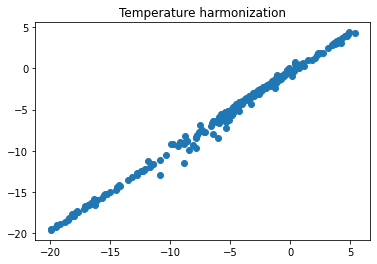

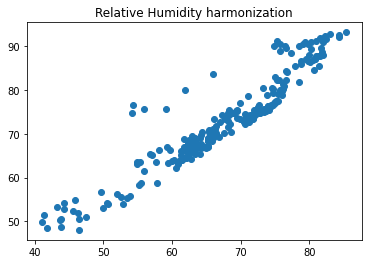

In [19]:
#get the data from harmonization
res_data = [harmonize(p) for p in parameters]

In [14]:
#get calibration factors and harmonized data
offset_means = [res_data[i][0] for i, _ in enumerate(parameters)]
offset_stds = [res_data[i][2] for i, _ in enumerate(parameters)]
harmonized_data = [res_data[i][1] for i, _ in enumerate(parameters)]


#save the calibration factors in a csv file
#TODO: add r2 values
for i, parameter in enumerate(parameters):
    if i == 0:
        df_calibration_factors = pd.DataFrame(np.column_stack([offset_means[i], offset_stds[i]]), columns=[f"{parameter} offset", f"{parameter} offset std"])
        df_calibration_factors.insert(0, "sensor", sensor_names)
        df_calibration_factors.to_csv(f'{result_folder}/offset_values.csv', index=False)
    else:
        df_calibration_factors = pd.read_csv(f'{result_folder}/offset_values.csv')
        df_calibration_factors[f"{parameter} offset"] = offset_means[i]
        df_calibration_factors[f"{parameter} offset std"] = offset_stds[i]
        df_calibration_factors.to_csv(f'{result_folder}/offset_values.csv', index=False)


In [9]:
#metadata of the calibration factors
def get_info(data_type: List, data_name: str):
    median, mean, min, max = np.nanmedian(data_type), np.mean(data_type), np.min(data_type), np.max(data_type)
    perc10, perc90 = np.percentile(data_type, 10), np.percentile(data_type, 90)

    print(f"for {data_name}:")
    print(f"median is {median}; mean is {mean.round(3)}")
    print(f"10the percentile is {perc10.round(2)}; 90the percentile is {perc90.round(2)}")
    print(f"min is {min}; max is {max}")


get_info(r2_values[1], "R2")


NameError: name 'r2_values' is not defined

In [24]:
#plotting each sensor vs median for convenient analysis

%matplotlib agg

parameter = 'PM 2.5'

#finding the median values for each timestamp - 'parameter_data' is 2-dimensional arrays to store the values of the parameter for all sensors
parameter_data = [data[i][parameter].values for i in range(n_sensors)]

#cut off sensors with missing days to find the median in a simpler way
parameter_data = np.array([parameter_data[i] for i in range(n_sensors)])
median = np.nanmedian(parameter_data, axis=0)

parameter_name = parameters[0]
sensor_ind = 1

#sensors_vs_median
median_folder = 'sensors_vs_median'
if not os.path.isdir(f'{result_folder}/{median_folder}'):
    os.mkdir(f'./{result_folder}/{median_folder}')

#for sensor_ind in range(n_sensors):
sensor_ind = 10
plt.figure(figsize=(16,9))
plt.plot(dates, data[sensor_ind][parameter_name], label=f'sensor {sensor_names[sensor_ind]}')
plt.plot(dates, median, label='median')
plt.legend()
plt.title(f'Sensor {sensor_names[sensor_ind]} vs median')
plt.savefig(f'{result_folder}/{median_folder}/{parameter_name}_sensor{sensor_names[sensor_ind]}_vs_median.png', dpi=300)


In [ ]:
#TODO
#for the universal code
#set protocol for the name of the csv files